<a href="https://colab.research.google.com/github/shahshawaiz/artwork-style-prediction/blob/master/artwork_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# # # misc commands
# # activate kaggle, download dataset
# import os
# os.environ['KAGGLE_USERNAME'] = "shahshawaiz" # username from the json file
# os.environ['KAGGLE_KEY'] = "476e4fb10eef6d9da79358d4df0db985" # key from the json file
# !kaggle competitions download -c painter-by-numbers -f train.zip

# # delete file
# !rm -rf sample_data

# # extract zip
# !unzip '/content/drive/My Drive/university/s3/lfi/project/data/train_1.zip'
# !unzip 'train.zip'

# # mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# pkgs installation
# !pip install tensorflow h5py pyyaml

In [0]:
# imports
import numpy as np
import pandas as pd
import os
import time
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from typing import Any, Dict, List, Optional, Pattern, Set, Tuple

In [0]:
# set env
PATH_GDRIVE = '/content/drive/My Drive/university/s3/lfi/project/data'
PATH_IMAGES = 'train'
PATH_IMAGES_ZIP = PATH_GDRIVE + '/train_1.zip'
PATH_METADATA = PATH_GDRIVE + '/all_data_info.csv'
PATH_IMAGES_DIR = os.listdir(PATH_IMAGES)
CHECKPOINT_PATH = "checkpoints/cp-{epoch:04d}.ckpt"
CHECKPOINT_PERIOD = 3
SLICE_SIZE = 10
NUM_CLASSES = 5 

In [0]:
# read dataset
def read_data():
  img_list = []
  img_missing_list = []

  # metadata
  metadata = pd.read_csv(PATH_METADATA)
  top_n_classes = metadata.groupby(['style']).style.value_counts().nlargest(NUM_CLASSES).index.get_level_values(0).values.tolist() # get first n classes
  metadata = metadata[metadata['style'].isin(top_n_classes)] # filter metadata w.r.t classes
  
  images_path = metadata['new_filename'].sample(n=SLICE_SIZE, random_state=1).values.tolist()
  metadata = metadata[metadata['new_filename'].isin(images_path)] # filter metadata w.r.t slice size

  # read images
  for filename in images_path:
      img_path = PATH_IMAGES + '/'+ filename	
      try:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        img_list.append(x)
      except OSError as e:
        print("File not found:", img_path)
        img_missing_list.append(filename)

  # convert to float32, fix shape
  images = np.array(img_list)
  images = images.astype('float32')
  images = np.rollaxis(images,1,0)

  # remove missing files from metadata
  metadata = metadata[~metadata['new_filename'].isin(img_missing_list)] 

  return images[0], metadata

def factorize(metadata):
	metadata['style_code'] = metadata['style'].astype('category')
	metadata['style_code'] = pd.factorize(metadata.style_code)[0]
	
	return metadata

def get_categories(labels):
	return np_utils.to_categorical(labels, NUM_CLASSES)
	
def shuffle_data(images, Y):
  x, y = shuffle(images, Y, random_state=2)
  return train_test_split(x, y, test_size=0.2, random_state=2)

In [0]:
def resnet_init():
  #image_input = Input(shape=(224, 224, 3))
  model = ResNet50(weights='imagenet', include_top=False)
  model.summary()  

  return model

In [0]:
def resnet_retrain_classifier(model):
  last_layer = model.output
  # add a global spatial average pooling layer
  x = GlobalAveragePooling2D()(last_layer)
  # add fully-connected & dropout layers
  x = Dense(512, activation='relu',name='fc-1')(x)
  x = Dropout(0.5)(x)
  x = Dense(256, activation='relu',name='fc-2')(x)
  x = Dropout(0.5)(x)
  # a softmax layer for n classes
  out = Dense(NUM_CLASSES, activation='softmax',name='output_layer')(x)  

  return out

In [0]:
def get_retrained_resnet(model, out):
  # # this is the model we will train
  model = Model(inputs=model.input, outputs=out)
  model.summary()

  for layer in model.layers[:-6]:
    layer.trainable = False

  model.layers[-1].trainable
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])  

  return model

In [0]:
def init_checkpoints():
  checkpoint_dir = os.path.dirname(CHECKPOINT_PATH)

  # create checkpount
  return ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, period=CHECKPOINT_PERIOD)

In [0]:
def model_create():
	model = resnet_init()
	out = resnet_retrain_classifier(model)
	
	return get_retrained_resnet(model, out)

In [0]:
def model_fit(
    model, X_train, y_train, X_test, y_test, cp_callback
):
  t=time.time()
  hist = model.fit(
      X_train, y_train, batch_size=32, epochs=12, verbose=1, validation_data=(X_test, y_test), callbacks=[cp_callback]
  )
  print('Training time: %s' % (t - time.time()))
  (loss, accuracy) = model.evaluate(X_test, y_test, batch_size=10, verbose=1)

  print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))  

  return model, hist

In [0]:
def model_visiualize(hist):
  
  import matplotlib.pyplot as plt
  # visualizing losses and accuracy
  train_loss=hist.history['loss']
  val_loss=hist.history['val_loss']
  train_acc=hist.history['acc']
  val_acc=hist.history['val_acc']
  xc=range(12)

  plt.figure(1,figsize=(7,5))
  plt.plot(xc,train_loss)
  plt.plot(xc,val_loss)
  plt.xlabel('num of Epochs')
  plt.ylabel('loss')
  plt.title('train_loss vs val_loss')
  plt.grid(True)
  plt.legend(['train','val'])
  #print plt.style.available # use bmh, classic,ggplot for big pictures
  plt.style.use(['classic'])

  plt.figure(2,figsize=(7,5))
  plt.plot(xc,train_acc)
  plt.plot(xc,val_acc)
  plt.xlabel('num of Epochs')
  plt.ylabel('accuracy')
  plt.title('train_acc vs val_acc')
  plt.grid(True)
  plt.legend(['train','val'],loc=4)
  #print plt.style.available # use bmh, classic,ggplot for big pictures
  plt.style.use(['classic'])  

File not found: train/49521.jpg
File not found: train/92964.jpg


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

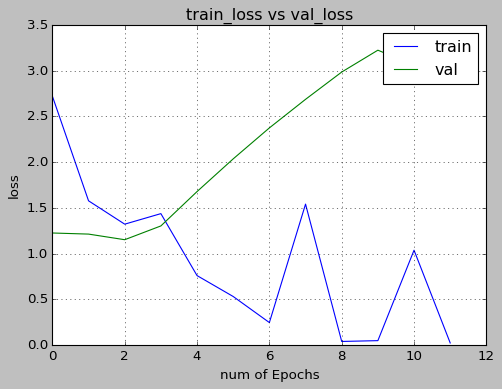

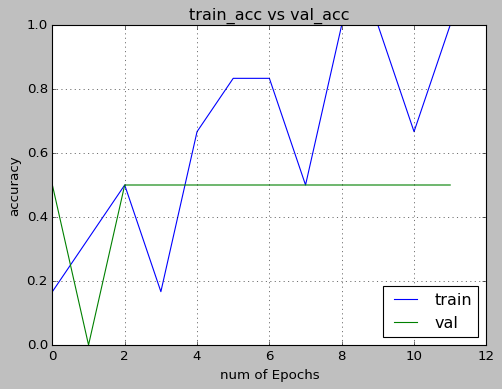

In [272]:
images, metadata = read_data()
metadata = factorize(metadata)
Y = get_categories(metadata.style_code)
X_train, X_test, y_train, y_test = shuffle_data(images, Y)

cp_callback = init_checkpoints()

model = model_create()
model, hist = model_fit(
    model, X_train, y_train, X_test, y_test, cp_callback
)

model_visiualize(hist)

